In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from interpolating_match import *
from calcwf import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


Taking a uniform distribution in SNR (ratio) and mapping to samples of eccentricity we find the following distribution:

In [2]:
# Load grid data
with open(os.path.join('grid_data', 'dataslot_48', 'all_matches'), 'rb') as fp:
        grid_data = pickle.load(fp)
    
# Find min and max
for chirp in grid_data.keys():
    for key in list(grid_data[chirp].keys()):
        if key not in ['fid_params', 'e_vals', 'ovlps', 'ovlps_perp'] and 'phase' not in key:
            grid_data[chirp][f'{key}_max'] = np.nanmax(np.array(grid_data[chirp][key]), axis=1)
            grid_data[chirp][f'{key}_min'] = np.nanmin(np.array(grid_data[chirp][key]), axis=1)

# Compute interpolation objects
interp_dict = {}
for key in ['h1_h0', 'h1_h-1_h0', 'h1_h-1_h2_h0', 'h1_h-1_h0_pc']:
    interp_dict[key] = create_min_max_interp(grid_data, list(grid_data.keys())[1], key)

/home/ben.patterson/projects/EccentricBinaries/notebooks/interpolating_match.py:280: ComplexWarning: Casting complex values to real discards the imaginary part
  ecc_arr[0][ecc_arr[0]==5] = max_interp(matches[ecc_arr[0]==5])
/home/ben.patterson/projects/EccentricBinaries/notebooks/interpolating_match.py:281: ComplexWarning: Casting complex values to real discards the imaginary part
  ecc_arr[1][ecc_arr[1]==5] = min_interp(matches[ecc_arr[1]==5])


Text(0.5, 0, '$e_{10}$')

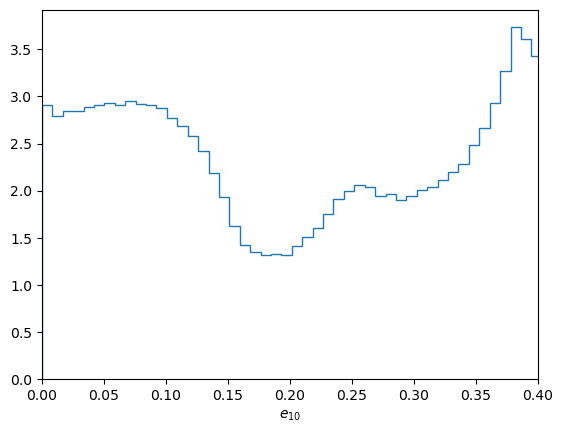

In [3]:
match_key = 'h1_h-1_h0_pc'
interps = interp_dict[match_key]
match_samples = np.linspace(0, 0.4, 10**6)
ecc_samples = SNR2ecc(match_samples, list(grid_data.keys())[1], interps, max_ecc=0.4, scaling_norms=[10, 0.035], upper_lenience=0.05)
plt.hist(ecc_samples, histtype='step', bins=50, density=True)
plt.xlim(0, 0.4)
plt.xlabel('$e_{10}$')

In order to enforce a flat eccentricity prior we must find a prior on the SNR samples that gives a flat distribution above. We can do this by mapping a flat eccentricity distribution 'in reverse' back to an SNR distribution. This can then be combined with the SNR distribution found by rejection sampling the ncx2 distrbution to find the overall SNR distribution which we can map through to get the final eccentricity distribution. This will remove the bimodal features we often see and will therefore hopefully end up with a much smoother gaussian-like structure.

First step is to reverse the mapping such that we can map samples on eccentricity to samples on SNR. Forward mapping works by drawing ecc value uniformly between min and max lines, so this reverse mapping should reflect this as well.

Will first go over all possible SNR values and find width of min/max lines at each point. Can then use inverse of these widths as weights for rejection sampling samples chosen uniformly between min and max lines at a given ecc value.

In [151]:
def ecc2SNR(eccs, chirp, interps, max_ecc=0.4, scaling_norms=[10, 0.035]):

    # Build 'inverse widths' for each SNR trial value
    SNR_trials = np.linspace(0, 1, 10**4)
    ecc_bounds = find_ecc_range_samples(SNR_trials, chirp, interps, max_ecc=max_ecc, scaling_norms=scaling_norms)
    iwidth_arr = 1/(ecc_bounds[1]-ecc_bounds[0])
    iwidth_interp = interp1d(SNR_trials, iwidth_arr)

    # Find max inverse width for each eccentricity
    upper_SNR = np.real(interps[0](eccs))
    lower_SNR = np.real(interps[1](eccs))
    upper_SNR[eccs>max_ecc] = 1
    lower_SNR[eccs>max_ecc] = np.real(interps[1](max_ecc))
    max_iwidths = []
    total_iwidths = []
    for i in range(len(eccs)):
        inds = np.asarray(np.logical_and(SNR_trials >= lower_SNR[i], SNR_trials <= upper_SNR[i])).nonzero()
        max_iwidths.append(np.max(iwidth_arr[inds]))
    max_iwidths = np.array(max_iwidths)
    
    # Draw SNR samples for each eccentricity using rejection sampling
    need_sample = np.full(len(eccs), True)
    SNR_samples = []
    count=0
    while True in need_sample:
        SNR_proposals = np.random.uniform(size=np.sum(need_sample))*(upper_SNR[need_sample]-lower_SNR[need_sample])+lower_SNR[need_sample]
        accepts = np.random.uniform(size=np.sum(need_sample))
        weights = iwidth_interp(SNR_proposals)/max_iwidths[need_sample]
        SNR_samples += list(SNR_proposals[weights>=accepts])
        need_sample[need_sample] = weights<accepts
        count+=1
        if count%1000==0:
            print(np.sum(need_sample))
    print(f'{count} loops')

    # upper_SNR = np.real(interps[0](eccs))
    # lower_SNR = np.real(interps[1](eccs))
    # upper_SNR[eccs>max_ecc] = 1
    # lower_SNR[eccs>max_ecc] = np.real(interps[1](max_ecc))
    # SNR_samples = np.random.uniform(size=len(eccs))*(upper_SNR-lower_SNR)+lower_SNR
        
    return SNR_samples

In [154]:
ecc_samples = np.linspace(0, 0.6, 10**6)
match_samples = ecc2SNR(ecc_samples, list(grid_data.keys())[1], interps, max_ecc=0.4, scaling_norms=[10, 0.035])

129 loops


(0.0, 0.4)

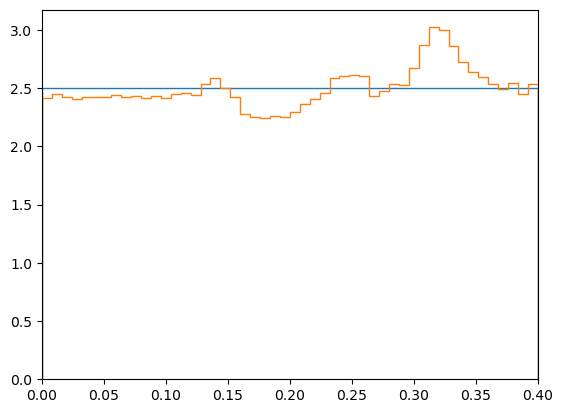

In [155]:
ecc_samples2 = SNR2ecc(match_samples, list(grid_data.keys())[1], interps, max_ecc=0.4, scaling_norms=[10, 0.035], upper_lenience=0.05)
plt.hist(ecc_samples[ecc_samples<=0.4], histtype='step', bins=50, density=True)
plt.hist(ecc_samples2[ecc_samples2<=0.4], histtype='step', bins=50, density=True)
plt.xlim(0,0.4)